# SAT-Based-Synthesis package for Qiskit


* **Using SAT-solver (namely Z3) to find depth- and count- optimal circuits for linear functions, cliffords, permutations, GHZ states, and more.**

* Alexander Ivrii: alexi@il.ibm.com


### Includes

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# TEMPORARY HACK TO ENABLE RUNNING SAT-SYNTHESIS CODE
import os
import sys
import pathlib

PACKAGE_PARENT = pathlib.Path.cwd().parent / "sat-based-synthesis"
SCRIPT_DIR = PACKAGE_PARENT
sys.path.append(str(SCRIPT_DIR))

In [4]:
import numpy as np

# Qiskit includes
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import LinearFunction
from qiskit.transpiler import CouplingMap
from qiskit.compiler import transpile

## Synthesizing linear circuits via Qiskit plugins

#### A simple quantum circuit with a single linear function

In [5]:
mat = np.array(
    [
        [1, 1, 0, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1],
        [1, 0, 1, 1, 0],
    ]
)
mat

array([[1, 1, 0, 1, 1],
       [0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 1, 1, 0]])

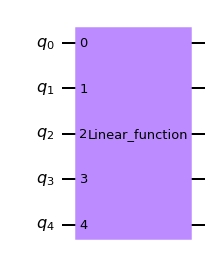

In [12]:
qc = QuantumCircuit(5)
qc.append(LinearFunction(mat), [0, 1, 2, 3, 4])
qc.draw("mpl")

#### Default transpilation

ops: OrderedDict([('cx', 8)]), depth: 6


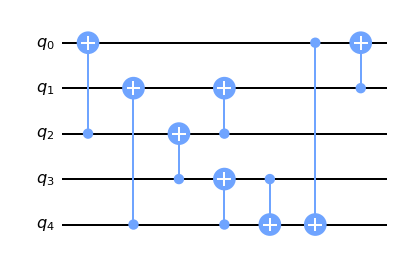

In [20]:
# Transpile (default)

tqc = transpile(qc)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### List available plugins for linear functions

In [21]:
from qiskit.transpiler.passes.synthesis.plugin import HighLevelSynthesisPluginManager

plugin_manager = HighLevelSynthesisPluginManager()
print(
    f"Linear function synthesis plugins: {plugin_manager.method_names('linear_function')}"
)

Linear function synthesis plugins: ['default', 'kms', 'pmh', 'sat_count', 'sat_depth']


#### Transpile using sat_count

ops: OrderedDict([('cx', 8), ('barrier', 8)]), depth: 8


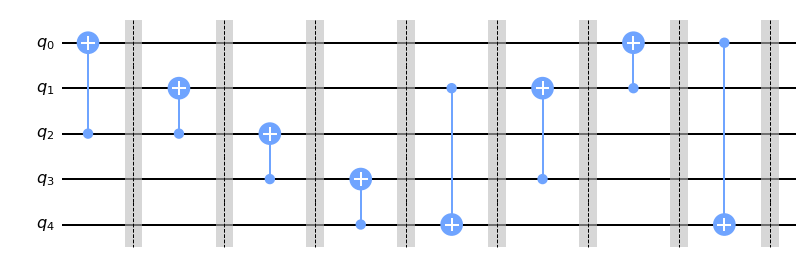

In [18]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig

hls_config = HLSConfig(linear_function=[("sat_count", {})])
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Transpile using sat_depth

ops: OrderedDict([('cx', 9), ('barrier', 5)]), depth: 5


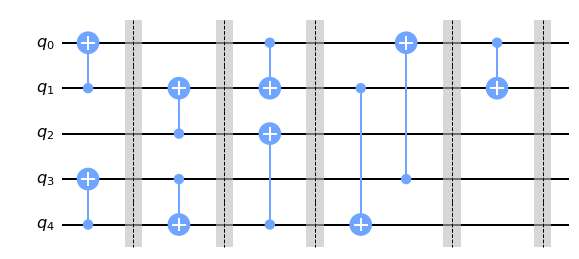

In [22]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig

hls_config = HLSConfig(linear_function=[("sat_depth", {})])
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

The "sat_depth" and "sat_count" plugins have a large number of additional options. The following example additionally optimizes the number of CX gates for the minimum depth, and increases the debug output verbosity

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 25,  #clauses = 50,  #assumptions = 0
 => sat-solver result: unsat in 0.02 s
 => synthesis problem result: no solutions in 0.02 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 115,  #clauses = 856,  #assumptions = 0
 => sat-solver result: unsat in 0.22 s
 => synthesis problem result: no solutions in 0.22 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 225,  #clauses = 1812,  #assumptions = 0
 => sat-solver result: unsat in 0.51 s
 => synthesis problem result: no solutions in 0.51 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 325,  #clauses = 2738,  #assumptions = 0
 => sa

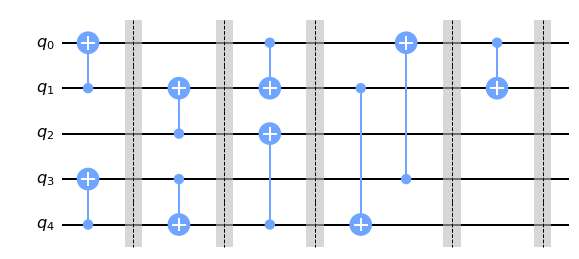

In [23]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig

hls_config = HLSConfig(
    linear_function=[("sat_depth", {"optimize_1q_gates": True, "verbosity": 1})]
)
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

## Working with the package directly

### Top-level approach: `synthesize_optimal`

* In a nutshell, we consider the problem _"Does there exist a circuit with at most `k` layers of CX-gates that implements a given linear matrix"_, translate it to CNF, and call Z3.

* Z3 returns whether the given problem is _satisfiable_ (has a solution), _unsatisfiable_ (has no solution), or _unknown_ (a resource limit such as _timeout_ or _max\_conflicts_ has been reached)

* The value of `k` is initially `0`, and is increased by `1` when the problem is unsatisfiable; in this way, the first satisfiable solution will necessarily have optimum depth

### Pre-packaged algorithms for synthesizing linear functions: `synthesize_linear_count` and `synthesize_linear_depth`

* These algorithms are suitable for most common tasks, and allows specifying the _coupling map_, the lists of clean and dirty ancilla qubits, the minimum and maximum depths to consider, whether to allow layout and final permutations, and more.

* These also make use of various search-space reduction constraints, such as: _"for depth-optimal synthesis do not allow solutions where some CX-gate can be moved to the previous layer"_, _"do not allow solutions with two consecutive CX gates over the same pair of qubits"_, or _"when a CX(i, j) gate is followed by a CX(i, k) gate, assume that `j<k`"_.

* These return `SynthesisResult` which includes the synthesized circuit (and some other information).

In [46]:
from synthesis.synthesize_linear import synthesize_linear_depth, synthesize_linear_count

line5 = list(CouplingMap.from_line(5).get_edges())  # line connectivity
full5 = list(CouplingMap.from_full(5).get_edges())  # all-to-all connectivity

#### Example: synthesis for all-to-all connectivity

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 25,  #clauses = 50,  #assumptions = 0
 => sat-solver result: unsat in 0.02 s
 => synthesis problem result: no solutions in 0.02 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 115,  #clauses = 856,  #assumptions = 0
 => sat-solver result: unsat in 0.2 s
 => synthesis problem result: no solutions in 0.2 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 225,  #clauses = 1812,  #assumptions = 0
 => sat-solver result: unsat in 0.43 s
 => synthesis problem result: no solutions in 0.43 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 325,  #clauses = 2738,  #assumptions = 0
 => sat-

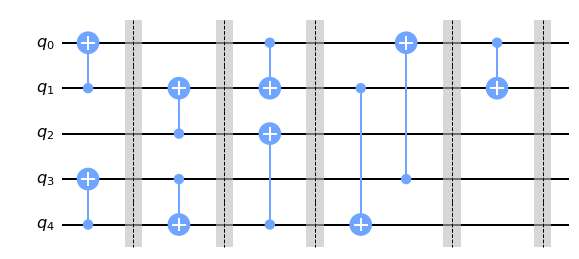

In [47]:
res = synthesize_linear_depth(mat, coupling_map=full5, verbosity=1)
res.circuit.draw("mpl")

#### Example: synthesis for line connectivity

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 25,  #clauses = 50,  #assumptions = 0
 => sat-solver result: unsat in 0.02 s
 => synthesis problem result: no solutions in 0.02 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 75,  #clauses = 394,  #assumptions = 0
 => sat-solver result: unsat in 0.11 s
 => synthesis problem result: no solutions in 0.11 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 133,  #clauses = 780,  #assumptions = 0
 => sat-solver result: unsat in 0.21 s
 => synthesis problem result: no solutions in 0.21 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 187,  #clauses = 1154,  #assumptions = 0
 => sat-

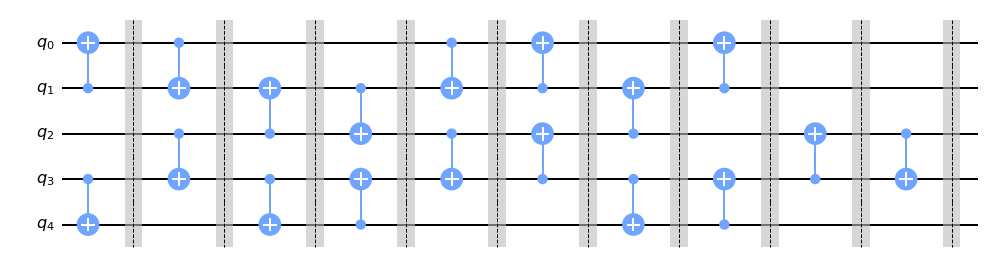

In [48]:
res = synthesize_linear_depth(
    mat, coupling_map=line5, print_solutions=False, verbosity=1
)
res.circuit.draw("mpl")

#### Example: additionally optimizing the number of 2-qubit gates for the given optimal depth

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 25,  #clauses = 50,  #assumptions = 0
 => sat-solver result: unsat in 0.02 s
 => synthesis problem result: no solutions in 0.02 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 75,  #clauses = 394,  #assumptions = 0
 => sat-solver result: unsat in 0.1 s
 => synthesis problem result: no solutions in 0.1 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 133,  #clauses = 780,  #assumptions = 0
 => sat-solver result: unsat in 0.21 s
 => synthesis problem result: no solutions in 0.21 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 187,  #clauses = 1154,  #assumptions = 0
 => sat-so

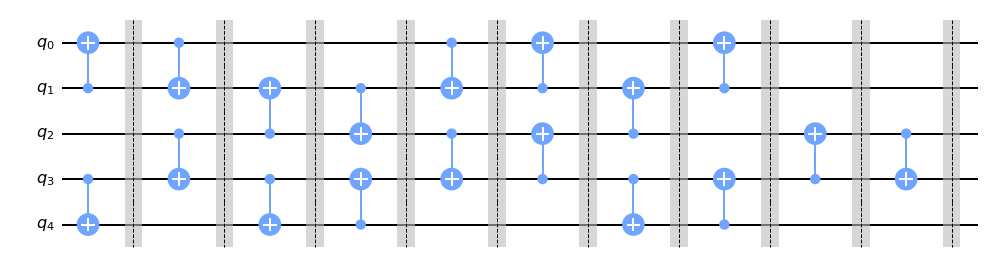

In [49]:
# set optimize_2q_gates to True to further minimize the number of 2q-gates (for the given optimal depth)
res = synthesize_linear_depth(
    mat, coupling_map=line5, verbosity=1, optimize_2q_gates=True
)
res.circuit.draw("mpl")

#### Example: asking for multiple solutions

Note that some solutions will be missed with the default search-space reduction constraints (though you can disable these)

In [53]:
res = synthesize_linear_depth(mat, coupling_map=full5, verbosity=1, max_solutions=5)

for i, solution in enumerate(res.solutions):
    print(f"Solution {i+1}:")
    print(solution.circuit)

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 25,  #clauses = 50,  #assumptions = 0
 => sat-solver result: unsat in 0.02 s
 => synthesis problem result: no solutions in 0.02 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 115,  #clauses = 856,  #assumptions = 0
 => sat-solver result: unsat in 0.23 s
 => synthesis problem result: no solutions in 0.23 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 225,  #clauses = 1812,  #assumptions = 0
 => sat-solver result: unsat in 0.49 s
 => synthesis problem result: no solutions in 0.49 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 325,  #clauses = 2738,  #assumptions = 0
 => sa

#### Example: synthesis "up to permutation on the output qubits"

In [56]:
res = synthesize_linear_depth(
    mat, coupling_map=line5, verbosity=1, allow_final_permutation=True
)
print(res.circuit)

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = True
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 125,  #clauses = 440,  #assumptions = 0
 => sat-solver result: unsat in 0.09 s
 => synthesis problem result: no solutions in 0.09 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 175,  #clauses = 784,  #assumptions = 0
 => sat-solver result: unsat in 0.18 s
 => synthesis problem result: no solutions in 0.18 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 233,  #clauses = 1170,  #assumptions = 0
 => sat-solver result: unsat in 0.26 s
 => synthesis problem result: no solutions in 0.26 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 287,  #clauses = 1544,  #assumptions = 0
 => s

In [57]:
# We can extract the actual permutation and display the circuit with this permutation included

print(res.solutions[0].final_permutation)
print(res.solutions[0].circuit_with_permutations)

[2, 4, 0, 3, 1]
           ░       ░       ░       ░       ░ ┌───┐ ░       
q_0: ──────░───■───░───────░───────░───────░─┤ X ├─░─────X─
           ░ ┌─┴─┐ ░       ░ ┌───┐ ░       ░ └─┬─┘ ░     │ 
q_1: ──■───░─┤ X ├─░───────░─┤ X ├─░───■───░───■───░──X──┼─
     ┌─┴─┐ ░ ├───┤ ░       ░ └─┬─┘ ░ ┌─┴─┐ ░ ┌───┐ ░  │  │ 
q_2: ┤ X ├─░─┤ X ├─░───■───░───■───░─┤ X ├─░─┤ X ├─░──┼──X─
     └───┘ ░ └─┬─┘ ░ ┌─┴─┐ ░       ░ ├───┤ ░ └─┬─┘ ░  │    
q_3: ──■───░───■───░─┤ X ├─░───■───░─┤ X ├─░───■───░──┼────
     ┌─┴─┐ ░       ░ └───┘ ░ ┌─┴─┐ ░ └─┬─┘ ░       ░  │    
q_4: ┤ X ├─░───────░───────░─┤ X ├─░───■───░───────░──X────
     └───┘ ░       ░       ░ └───┘ ░       ░       ░       


#### Example: synthesis "up to layout permutation"

In [58]:
res = synthesize_linear_depth(
    mat, coupling_map=line5, verbosity=1, allow_layout_permutation=True
)
print(res.circuit)

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = True, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 150,  #clauses = 690,  #assumptions = 0
 => sat-solver result: unsat in 0.17 s
 => synthesis problem result: no solutions in 0.17 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 200,  #clauses = 1034,  #assumptions = 0
 => sat-solver result: unsat in 0.25 s
 => synthesis problem result: no solutions in 0.25 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 258,  #clauses = 1420,  #assumptions = 0
 => sat-solver result: unsat in 0.36 s
 => synthesis problem result: no solutions in 0.36 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 312,  #clauses = 1794,  #assumptions = 0
 => 

## Possible application: resynthesizing linear circuits in Qiskit

Given a quantum circuit with linear gates, we can convert it to linear function, 
and then to synthesize the corresponding matrix (as we were doing all along)

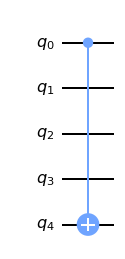

In [63]:
qc1 = QuantumCircuit(5)
qc1.cx(0, 4)
qc1.draw(output="mpl")

In [64]:
linfunc1 = LinearFunction(qc1)
print(linfunc1.mat_str())
print(linfunc1.function_str())
mat1 = linfunc1.linear

[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 1]]
(x_0, x_1, x_2, x_3, x_0 + x_4)



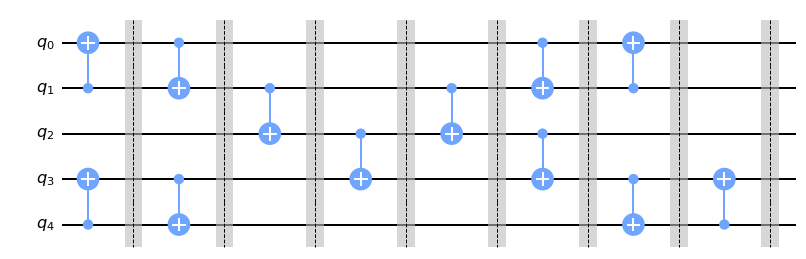

In [62]:
res = synthesize_linear_depth(
    mat1, coupling_map=line5, verbosity=0, optimize_2q_gates=True
)
res.circuit.draw("mpl")

In [66]:
# And we can double-check that we got the right matrix
print(LinearFunction(res.circuit) == LinearFunction(qc1))

True


### What if prepackaged algorithms are not enough?

- We can create _custom_ linear (and also clifford, permutation, GHZ, etc.) problems by specifying and restricting layers in the solution
- And use the function `synthesize_optimal` (that we have discussed before) to find an optimal solution

In [72]:
from synthesis.synthesize import SynthesisResult, synthesize_optimal
from synthesis.sat_problem_linear import SatProblemLinear

#### Simple version of the SAT problem for linear function synthesis (e.g., without search-space reduction constraints)

In [73]:
def create_my_problem(mat, depth2q):
    nq = len(mat)
    coupling_map = list(CouplingMap.from_line(nq).get_edges())
    sat_problem = SatProblemLinear(nq, verbosity=0)
    sat_problem.set_init_matrix_to_identity(nq)
    for _ in range(depth2q):
        sat_problem.add_layer(
            gates=["CX"],
            coupling_maps=[coupling_map],
        )
    sat_problem.set_final_matrix(mat)
    sat_problem.set_check_solutions(True)
    sat_problem.set_print_solutions(True)
    return sat_problem

In [74]:
print(mat)

[[1 1 0 1 1]
 [0 1 1 1 1]
 [0 0 1 1 0]
 [0 0 0 1 1]
 [1 0 1 1 0]]


In [75]:
# Starting from depth=0, creates the SAT-problem, solves it, incrementally increases depth till a solution is found
res = synthesize_optimal(
    target_obj=mat, create_sat_problem_fn=create_my_problem, verbosity=1
)

Looking for solution with target depth 0
Looking for solution with target depth 1
Looking for solution with target depth 2
Looking for solution with target depth 3
Looking for solution with target depth 4
Looking for solution with target depth 5
Looking for solution with target depth 6
Looking for solution with target depth 7
Looking for solution with target depth 8
Looking for solution with target depth 9
Looking for solution with target depth 10
Printing solution
     ┌───┐ ░       ░       ░       ░ ┌───┐ ░       ░ ┌───┐ ░       ░       ░ »
q_0: ┤ X ├─░───■───░───────░───────░─┤ X ├─░───■───░─┤ X ├─░───────░───■───░─»
     └─┬─┘ ░ ┌─┴─┐ ░ ┌───┐ ░       ░ └─┬─┘ ░ ┌─┴─┐ ░ └─┬─┘ ░ ┌───┐ ░ ┌─┴─┐ ░ »
q_1: ──■───░─┤ X ├─░─┤ X ├─░───■───░───■───░─┤ X ├─░───■───░─┤ X ├─░─┤ X ├─░─»
           ░ └───┘ ░ └─┬─┘ ░ ┌─┴─┐ ░       ░ ├───┤ ░       ░ └─┬─┘ ░ ├───┤ ░ »
q_2: ──────░───■───░───■───░─┤ X ├─░───■───░─┤ X ├─░───────░───■───░─┤ X ├─░─»
           ░ ┌─┴─┐ ░       ░ ├───┤ ░ ┌─┴─┐ ░ └─┬─┘ ░    

In [76]:
print(LinearFunction(res.circuit) == LinearFunction(mat))

True


#### Suppose we can use both CX or SWAP gates

In [77]:
def create_my_problem_2(mat, depth2q):
    nq = len(mat)
    coupling_map = list(CouplingMap.from_line(nq).get_edges())
    sat_problem = SatProblemLinear(nq, verbosity=0)
    sat_problem.set_init_matrix_to_identity(nq)
    for _ in range(depth2q):
        sat_problem.add_layer(
            gates=["CX", "SWAP"],
            coupling_maps=[coupling_map],
        )
    sat_problem.set_final_matrix(mat)
    sat_problem.set_check_solutions(True)
    sat_problem.set_print_solutions(True)
    return sat_problem


res = synthesize_optimal(
    target_obj=mat, create_sat_problem_fn=create_my_problem_2, verbosity=1
)

print(LinearFunction(res.circuit) == LinearFunction(mat))

Looking for solution with target depth 0
Looking for solution with target depth 1
Looking for solution with target depth 2
Looking for solution with target depth 3
Looking for solution with target depth 4
Looking for solution with target depth 5
Looking for solution with target depth 6
Looking for solution with target depth 7
Printing solution
           ░       ░ ┌───┐ ░       ░ ┌───┐ ░       ░       ░ 
q_0: ──X───░───────░─┤ X ├─░───────░─┤ X ├─░───────░───■───░─
       │   ░       ░ └─┬─┘ ░       ░ └─┬─┘ ░       ░ ┌─┴─┐ ░ 
q_1: ──X───░───■───░───■───░───X───░───■───░───X───░─┤ X ├─░─
           ░ ┌─┴─┐ ░       ░   │   ░       ░   │   ░ └───┘ ░ 
q_2: ──────░─┤ X ├─░───X───░───X───░───X───░───X───░───X───░─
           ░ └───┘ ░   │   ░       ░   │   ░ ┌───┐ ░   │   ░ 
q_3: ──■───░───X───░───X───░───■───░───X───░─┤ X ├─░───X───░─
     ┌─┴─┐ ░   │   ░       ░ ┌─┴─┐ ░       ░ └─┬─┘ ░       ░ 
q_4: ┤ X ├─░───X───░───────░─┤ X ├─░───────░───■───░───────░─
     └───┘ ░       ░       ░ └───┘

#### Suppose that we can use CX, SWAP and DCX gates

In [78]:
def create_my_problem_3(mat, depth2q):
    nq = len(mat)
    coupling_map = list(CouplingMap.from_line(nq).get_edges())
    sat_problem = SatProblemLinear(nq, verbosity=0)
    sat_problem.set_init_matrix_to_identity(nq)
    for _ in range(depth2q):
        sat_problem.add_layer(
            gates=["CX", "SWAP", "DCX"],
            coupling_maps=[coupling_map],
        )
    sat_problem.set_final_matrix(mat)
    sat_problem.set_check_solutions(True)
    sat_problem.set_print_solutions(True)
    return sat_problem


res = synthesize_optimal(
    target_obj=mat, create_sat_problem_fn=create_my_problem_3, verbosity=1
)

print(LinearFunction(res.circuit) == LinearFunction(mat))

Looking for solution with target depth 0
Looking for solution with target depth 1
Looking for solution with target depth 2
Looking for solution with target depth 3
Looking for solution with target depth 4
Looking for solution with target depth 5
Looking for solution with target depth 6
Printing solution
              ░     ░       ░  ┌───┐   ░          ░ ┌──────┐ ░ 
q_0: ─────────░──X──░───────░──┤ X ├───░──────────░─┤1     ├─░─
      ┌───┐   ░  │  ░       ░  └─┬─┘   ░          ░ │  Dcx │ ░ 
q_1: ─┤ X ├───░──X──░───X───░────■─────░────X─────░─┤0     ├─░─
      └─┬─┘   ░     ░   │   ░ ┌──────┐ ░    │     ░ └──────┘ ░ 
q_2: ───■─────░──X──░───X───░─┤1     ├─░────X─────░────X─────░─
     ┌──────┐ ░  │  ░       ░ │  Dcx │ ░ ┌──────┐ ░    │     ░ 
q_3: ┤1     ├─░──X──░───■───░─┤0     ├─░─┤0     ├─░────X─────░─
     │  Dcx │ ░     ░ ┌─┴─┐ ░ └──────┘ ░ │  Dcx │ ░          ░ 
q_4: ┤0     ├─░─────░─┤ X ├─░──────────░─┤1     ├─░──────────░─
     └──────┘ ░     ░ └───┘ ░          ░ └──────┘ ░    

### What if even this is not enough?

* The class `SatProblemLinear` (that we have implicitly used all the time until now), models linear circuits using `n x n` binary matrices and describes how these matrices change when applying a gate (or a layer of gates). 

* Of course, not every problem can be modeled in this way: e.g., Clifford problems are modeled using `2n x 2n` binary symplectic matrices.

* And some problems (such as GHZ state preparation) can be modeled in a significantly simpler way (making them more scalable for SAT).

* This is why we also have classes `SatProblemClifford`, `SatProblemPermutation`, `SatProblemSuperposed` and more.

* The idea is that the "base class" `SatProblem` is as generic as possible, while its subclasses implement problem-specific functionality.

## More examples


In [80]:
from synthesis.synthesize_permutation import synthesize_permutation_depth
from synthesis.utils import perm_matrix

#### Example: synthesing cyclic shift permutations

In [83]:
# This is cyclic shift: 1->0, 2->1, 0->2

perm = [1, 2, 3, 4, 5, 6, 7, 0]
mat = perm_matrix(perm)
coupling_map = list(CouplingMap.from_line(8).get_edges())

result = synthesize_permutation_depth(
    mat=mat,
    coupling_map=coupling_map,
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=0,
)

Printing solution
         ░     ░     ░     ░     ░     ░     ░ 
q_0: ─X──░─────░─────░─────░─────░─────░─────░─
      │  ░     ░     ░     ░     ░     ░     ░ 
q_1: ─X──░──X──░─────░─────░─────░─────░─────░─
         ░  │  ░     ░     ░     ░     ░     ░ 
q_2: ────░──X──░──X──░─────░─────░─────░─────░─
         ░     ░  │  ░     ░     ░     ░     ░ 
q_3: ────░─────░──X──░──X──░─────░─────░─────░─
         ░     ░     ░  │  ░     ░     ░     ░ 
q_4: ────░─────░─────░──X──░──X──░─────░─────░─
         ░     ░     ░     ░  │  ░     ░     ░ 
q_5: ────░─────░─────░─────░──X──░──X──░─────░─
         ░     ░     ░     ░     ░  │  ░     ░ 
q_6: ────░─────░─────░─────░─────░──X──░──X──░─
         ░     ░     ░     ░     ░     ░  │  ░ 
q_7: ────░─────░─────░─────░─────░─────░──X──░─
         ░     ░     ░     ░     ░     ░     ░ 


#### Example: also require at most 3 unique layers

In [84]:
# Let's request at most 3 unique layers
result = synthesize_permutation_depth(
    mat=mat,
    coupling_map=coupling_map,
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    max_num_unique_layers=3,
    verbosity=0,
)

Printing solution
         ░     ░     ░     ░     ░     ░     ░     ░     ░ 
q_0: ────░──X──░─────░──X──░─────░─────░──X──░─────░──X──░─
         ░  │  ░     ░  │  ░     ░     ░  │  ░     ░  │  ░ 
q_1: ─X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░─
      │  ░     ░  │  ░     ░  │  ░  │  ░     ░  │  ░     ░ 
q_2: ─X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░─
         ░  │  ░     ░  │  ░     ░     ░  │  ░     ░  │  ░ 
q_3: ─X──░──X──░──X──░──X──░─────░──X──░──X──░──X──░──X──░─
      │  ░     ░  │  ░     ░     ░  │  ░     ░  │  ░     ░ 
q_4: ─X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░─
         ░  │  ░     ░  │  ░  │  ░     ░  │  ░     ░  │  ░ 
q_5: ─X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░─
      │  ░     ░  │  ░     ░     ░  │  ░     ░  │  ░     ░ 
q_6: ─X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░──X──░─
         ░  │  ░     ░  │  ░  │  ░     ░  │  ░     ░  │  ░ 
q_7: ────░──X──░─────░──X──░──X──░─────░──X──░─────░──X──░─
         ░     ░     ░

#### Example: require at most 2 unique layers

* I don't think there is a solution, but we can set a limit on `max_depth2q`  

In [85]:
result = synthesize_permutation_depth(
    mat=mat,
    coupling_map=coupling_map,
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    max_num_unique_layers=2,
    verbosity=1,
    max_depth2q=20,
)

Running permutation synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 64,  #clauses = 128,  #assumptions = 0
 => sat-solver result: unsat in 0.02 s
 => synthesis problem result: no solutions in 0.02 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 143,  #clauses = 509,  #assumptions = 0
 => sat-solver result: unsat in 0.1 s
 => synthesis problem result: no solutions in 0.1 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 222,  #clauses = 890,  #assumptions = 0
 => sat-solver result: unsat in 0.2 s
 => synthesis problem result: no solutions in 0.2 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 331,  #clauses = 1395,  #assumptions = 0
 => s

#### We can also set limits on each individual Z3 sat query

In [86]:
result = synthesize_permutation_depth(
    mat=mat,
    coupling_map=coupling_map,
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    max_num_unique_layers=2,
    verbosity=1,
    max_conflicts_per_call=100,
)

Running permutation synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 64,  #clauses = 128,  #assumptions = 0
 => sat-solver result: unsat in 0.03 s
 => synthesis problem result: no solutions in 0.03 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 143,  #clauses = 509,  #assumptions = 0
 => sat-solver result: unsat in 0.12 s
 => synthesis problem result: no solutions in 0.12 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 222,  #clauses = 890,  #assumptions = 0
 => sat-solver result: unsat in 0.2 s
 => synthesis problem result: no solutions in 0.2 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 331,  #clauses = 1395,  #assumptions = 0
 =>

#### Example: permutations on grids

In [88]:
# Note that in general coupling maps are directed, but for SWAP gates it does not matter

grid9 = [
    [0, 1],
    [1, 2],
    [3, 4],
    [4, 5],
    [6, 7],
    [7, 8],
    [0, 3],
    [1, 4],
    [2, 5],
    [3, 6],
    [4, 7],
    [5, 8],
]

# reversal permutation
perm = [8, 7, 6, 5, 4, 3, 2, 1, 0]

mat = mat = perm_matrix(perm)

result = synthesize_permutation_depth(
    mat=mat,
    coupling_map=grid9,
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=0,
)

Printing solution
            ░        ░        ░        ░ 
q_0: ─X─────░──X─────░──X─────░──X─────░─
      │     ░  │     ░  │     ░  │     ░ 
q_1: ─X─────░──┼──X──░──X─────░──┼──X──░─
            ░  │  │  ░        ░  │  │  ░ 
q_2: ─X─────░──┼──X──░──X─────░──┼──X──░─
      │     ░  │     ░  │     ░  │     ░ 
q_3: ─┼──X──░──X─────░──┼──X──░──X─────░─
      │  │  ░        ░  │  │  ░        ░ 
q_4: ─┼──┼──░────────░──┼──┼──░────────░─
      │  │  ░        ░  │  │  ░        ░ 
q_5: ─X──┼──░──X─────░──X──┼──░──X─────░─
         │  ░  │     ░     │  ░  │     ░ 
q_6: ────X──░──┼──X──░─────X──░──┼──X──░─
            ░  │  │  ░        ░  │  │  ░ 
q_7: ────X──░──┼──X──░──X─────░──┼──X──░─
         │  ░  │     ░  │     ░  │     ░ 
q_8: ────X──░──X─────░──X─────░──X─────░─
            ░        ░        ░        ░ 


#### Example: specifying multiple coupling maps

* Every layer must conform to one of these maps

In [89]:
# Let's restrict each layer to have either vertical or horizontal gates, but not both
hor9 = [[0, 1], [1, 2], [3, 4], [4, 5], [6, 7], [7, 8]]
ver9 = [[0, 3], [1, 4], [2, 5], [3, 6], [4, 7], [5, 8]]

result = synthesize_permutation_depth(
    mat=mat,
    coupling_map_list=[hor9, ver9],
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=0,
)

Printing solution
         ░        ░        ░        ░     ░     ░ 
q_0: ─X──░──X─────░────────░──X─────░──X──░─────░─
      │  ░  │     ░        ░  │     ░  │  ░     ░ 
q_1: ─X──░──┼─────░──X─────░──┼─────░──X──░──X──░─
         ░  │     ░  │     ░  │     ░     ░  │  ░ 
q_2: ────░──┼──X──░──┼─────░──┼──X──░─────░──X──░─
         ░  │  │  ░  │     ░  │  │  ░     ░     ░ 
q_3: ────░──X──┼──░──┼──X──░──X──┼──░──X──░─────░─
         ░     │  ░  │  │  ░     │  ░  │  ░     ░ 
q_4: ─X──░──X──┼──░──X──┼──░──X──┼──░──X──░──X──░─
      │  ░  │  │  ░     │  ░  │  │  ░     ░  │  ░ 
q_5: ─X──░──┼──X──░──X──┼──░──┼──X──░─────░──X──░─
         ░  │     ░  │  │  ░  │     ░     ░     ░ 
q_6: ────░──┼─────░──┼──X──░──┼─────░─────░──X──░─
         ░  │     ░  │     ░  │     ░     ░  │  ░ 
q_7: ─X──░──X─────░──┼─────░──X─────░──X──░──X──░─
      │  ░        ░  │     ░        ░  │  ░     ░ 
q_8: ─X──░────────░──X─────░────────░──X──░─────░─
         ░        ░        ░        ░     ░     ░ 


In [90]:
# We can take this even further
hor9even = [[0, 1], [3, 4], [6, 7]]
hor9odd = [[1, 2], [4, 5], [7, 8]]
ver9even = [[0, 3], [1, 4], [2, 5]]
ver9odd = [[1, 4], [4, 7], [5, 8]]

result = synthesize_permutation_depth(
    mat=mat,
    coupling_map_list=[hor9even, hor9odd, ver9even, ver9odd],
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=0,
)

Printing solution
         ░           ░        ░     ░     ░     ░           ░ 
q_0: ────░──X────────░────────░──X──░─────░─────░──X────────░─
         ░  │        ░        ░  │  ░     ░     ░  │        ░ 
q_1: ─X──░──┼──X─────░────────░──X──░─────░──X──░──┼──X─────░─
      │  ░  │  │     ░        ░     ░     ░  │  ░  │  │     ░ 
q_2: ─X──░──┼──┼──X──░────────░─────░─────░──X──░──┼──┼──X──░─
         ░  │  │  │  ░        ░     ░     ░     ░  │  │  │  ░ 
q_3: ────░──X──┼──┼──░────────░──X──░─────░─────░──X──┼──┼──░─
         ░     │  │  ░        ░  │  ░     ░     ░     │  │  ░ 
q_4: ─X──░─────X──┼──░──X─────░──X──░──X──░──X──░─────X──┼──░─
      │  ░        │  ░  │     ░     ░  │  ░  │  ░        │  ░ 
q_5: ─X──░────────X──░──┼──X──░─────░──┼──░──X──░────────X──░─
         ░           ░  │  │  ░     ░  │  ░     ░           ░ 
q_6: ────░───────────░──┼──┼──░──X──░──┼──░─────░───────────░─
         ░           ░  │  │  ░  │  ░  │  ░     ░           ░ 
q_7: ─X──░───────────░──X──┼──░──X──░

#### Example: GHZ states

In [91]:
hor9even = [[0, 1], [3, 4], [6, 7], [1, 0], [4, 3], [7, 6]]
hor9odd = [[1, 2], [4, 5], [7, 8], [2, 1], [5, 4], [8, 7]]
ver9even = [[0, 3], [1, 4], [2, 5], [3, 0], [4, 1], [5, 2]]
ver9odd = [[3, 6], [4, 7], [5, 8], [6, 3], [7, 4], [8, 5]]

from synthesis.synthesize_superposed import (
    synthesize_superposed_count2q,
    synthesize_superposed_depth2q,
)

result = synthesize_superposed_depth2q(
    [1, 0, 1, 0, 1, 0, 1, 0, 1],
    coupling_map_list=[hor9even, hor9odd, ver9even, ver9odd],
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=1,
)

Running superposed state synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False, root = None
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 18,  #clauses = 35,  #assumptions = 0
 => sat-solver result: unsat in 0.02 s
 => synthesis problem result: no solutions in 0.02 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 116,  #clauses = 415,  #assumptions = 0
 => sat-solver result: unsat in 0.11 s
 => synthesis problem result: no solutions in 0.11 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 214,  #clauses = 795,  #assumptions = 0
 => sat-solver result: unsat in 0.17 s
 => synthesis problem result: no solutions in 0.17 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 312,  #clauses = 1175,  #

In [92]:
hor9even = [[0, 1], [3, 4], [6, 7], [1, 0], [4, 3], [7, 6]]
hor9odd = [[1, 2], [4, 5], [7, 8], [2, 1], [5, 4], [8, 7]]
ver9even = [[0, 3], [1, 4], [2, 5], [3, 0], [4, 1], [5, 2]]
ver9odd = [[3, 6], [4, 7], [5, 8], [6, 3], [7, 4], [8, 5]]

from synthesis.synthesize_superposed import (
    synthesize_superposed_count2q,
    synthesize_superposed_depth2q,
)

# Require layers to be full
result = synthesize_superposed_depth2q(
    [1, 0, 1, 0, 1, 0, 1, 0, 1],
    coupling_map_list=[hor9even, hor9odd, ver9even, ver9odd],
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=1,
    full_2q=True,
    max_depth2q=10,
)

Running superposed state synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False, root = None
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 18,  #clauses = 35,  #assumptions = 0
 => sat-solver result: unsat in 0.01 s
 => synthesis problem result: no solutions in 0.01 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 116,  #clauses = 427,  #assumptions = 0
 => sat-solver result: unsat in 0.09 s
 => synthesis problem result: no solutions in 0.09 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 214,  #clauses = 819,  #assumptions = 0
 => sat-solver result: unsat in 0.18 s
 => synthesis problem result: no solutions in 0.18 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 312,  #clauses = 1211,  #

In [93]:
# Another example with odd-even layers
from synthesis.synthesize_superposed import (
    synthesize_superposed_count2q,
    synthesize_superposed_depth2q,
)

result = synthesize_superposed_depth2q(
    [1, 0, 1, 0, 1],
    coupling_map_list=[
        [[0, 1], [1, 0], [2, 3], [3, 2]],
        [[1, 2], [2, 1], [3, 4], [4, 3]],
    ],
    print_solutions=True,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=1,
    max_depth2q=10,
    full_2q=True,
)

Running superposed state synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False, root = None
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 10,  #clauses = 19,  #assumptions = 0
 => sat-solver result: unsat in 0.01 s
 => synthesis problem result: no solutions in 0.01 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 42,  #clauses = 144,  #assumptions = 0
 => sat-solver result: unsat in 0.04 s
 => synthesis problem result: no solutions in 0.04 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 74,  #clauses = 269,  #assumptions = 0
 => sat-solver result: unsat in 0.06 s
 => synthesis problem result: no solutions in 0.06 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 106,  #clauses = 394,  #ass